<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/PAPER_GDRNet_Step4-RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

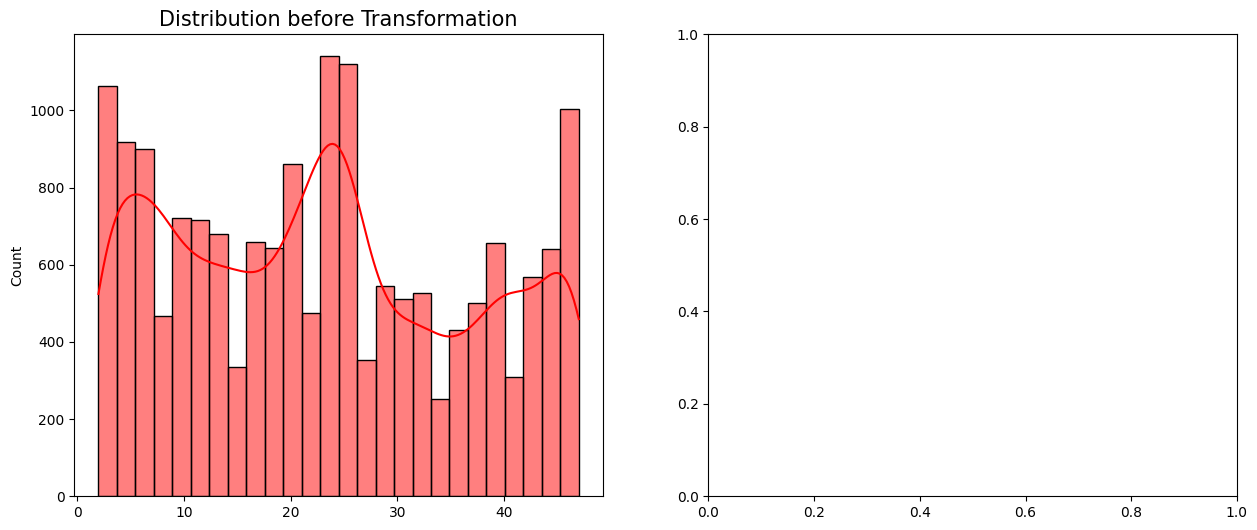

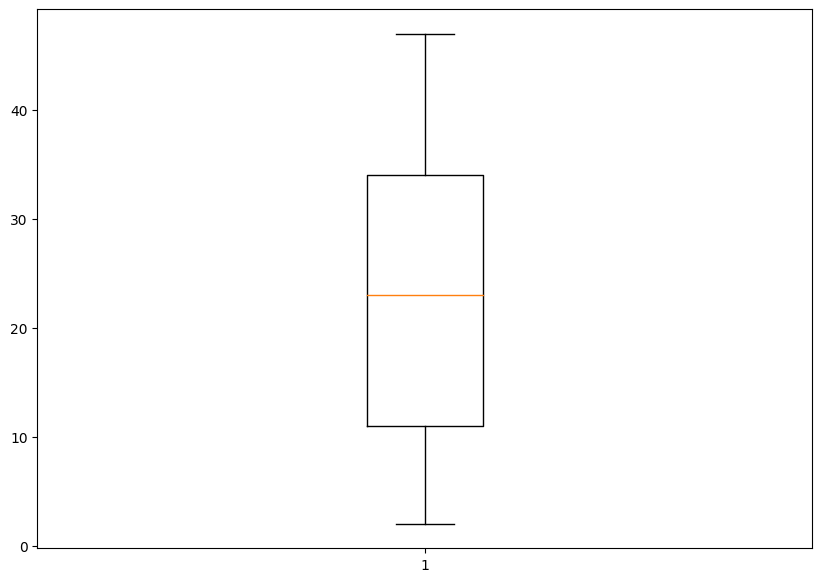

RMSE: 1.146491602105908 0.882437223133078 1.7790197712700044 0.6238596098726373 0.6199548667100886
MAPE: 2.5689030418005845 3.222022644493985 15.413320557146598 3.934888926790442 1.419232365370566
MAE: 0.2387792865748135 0.17476209340698193 0.13908874427199067 0.09509738198158907 0.15104440634883803


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import scipy.stats as stats
from numpy import array
from numpy import hstack
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.linear_model import LinearRegression
from keras.models import Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestRegressor
from numpy import arange
#-----------------------------------------------------GET DATA - X, Predicted Wndow from MLP, and Derived Labels, for the entire dataset that was gennerated through VAE-----------------------------------

#-----------for test dataset-----------------------------------------------------------------------
y_pred = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/AQ_predicted_window.csv')
y_true = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/AQ_derived_window_label.csv')
x_orig = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/AQ_test_data.csv')


n_features = 12
n_future = 1
window_size = int(x_orig.shape[1]/n_features)
x = x_orig.reshape((x_orig.shape[0],window_size,n_features))

sample_size = 5000
#-----------------------------------------------CASES - pot window values and pick a few fixed window sizes -------------------------------------------

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(y_true, kde=True, color="red")
plt.subplot(1,2,2)

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.boxplot(y_true)
# show plot
plt.show()

fx_window1 = 10
fx_window2 = 20
fx_window3 = 30
fx_window4 = 40
pred_step = n_future=1

se_1 = list()
se_2 = list()
se_3 = list()
se_4 = list()
se_x = list()

ape_1 = list()
ape_2 = list()
ape_3 = list()
ape_4 = list()
ape_x = list()

ae_1 = list()
ae_2 = list()
ae_3 = list()
ae_4 = list()
ae_x = list()



################---------------------------METHOD 2- -GO BY RMSE----------------------------------------------------####################

def generate_small_seq(series, n_past, n_future):
  #
  # n_past ==> no of past observations -- OR -- sliding window
  #
  # n_future ==> no of future observations -- prediction variable y
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, 1] #We just take the active power as the prediction variable
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

se_1 = list()
se_2 = list()
se_3 = list()
se_4 = list()
se_x = list()

ape_1 = list()
ape_2 = list()
ape_3 = list()
ape_4 = list()
ape_x = list()

ae_1 = list()
ae_2 = list()
ae_3 = list()
ae_4 = list()
ae_x = list()


min_window_list = list()
best_window_for_long_seq = list()
AIC = list()
n_fold = 6 # 5 fold plus 1 for test)
# evaluate a logistic regression model using k-fold cross-validation
n_future=1
predictions = list()


from numpy import mean
from numpy import std

best_window_for_long_seq.clear()

#window_list = [fx_window1, fx_window2, fx_window3, fx_window4]
########------------Window 1-------------------------


############## Window 1-----------------------------------
se_1.clear()
ape_1.clear()
ae_1.clear()
for i in range(sample_size) :
#iterate over the entire  long sequences of multivariate time series
  Total_small_seq_X, Total_small_seq_y = generate_small_seq(x[i,:,:], fx_window1 , n_future)
  Total_small_seq_X_reshaped = Total_small_seq_X.reshape(Total_small_seq_X.shape[0],Total_small_seq_X.shape[1]*Total_small_seq_X.shape[2])
  Total_small_seq_y_reshaped = Total_small_seq_y
  maxval2 = Total_small_seq_X_reshaped.shape[0]
  count_train2 = int(math.ceil(0.7*maxval2))
  Small_train_X = Total_small_seq_X_reshaped[0:count_train2]
  Small_train_y = Total_small_seq_y_reshaped[0:count_train2]
  Small_test_X =  Total_small_seq_X_reshaped[count_train2:]
  Small_test_y = Total_small_seq_y_reshaped[count_train2:]
  tscv = TimeSeriesSplit(n_splits=n_fold-1)
  #regressor = LassoCV(alphas=0.1)
  regressor = LinearRegression()
  try:
    regressor.fit(Small_train_X, Small_train_y.ravel()) #get jth time series only
    if Small_test_X.shape[0] == 0:
      break
    y_predk = regressor.predict(Small_test_X)
    #print('alpha: %f' % regressor.alpha_)
    se =  ((Small_test_y-y_predk)**2).mean()/abs(Small_test_y.mean())
    ape = abs(Small_test_y-y_predk).mean()/abs(Small_test_y.mean())
    ae = abs(Small_test_y-y_predk).mean()
    #mse = mean_squared_error(Small_test_y, y_predk)
    #print(rmse)
    se_1.append(se)
    ape_1.append(ape)
    ae_1.append(ae)
  except:
    se_1.append(9999)
    ape_1.append(9999)
    ae_1.append(9999)
    print('error')



############## Window 2-----------------------------------
se_2.clear()
ape_2.clear()
ae_2.clear()
for i in range(sample_size) :
#iterate over the entire  long sequences of multivariate time series
  Total_small_seq_X, Total_small_seq_y = generate_small_seq(x[i,:,:], fx_window2 , n_future)
  Total_small_seq_X_reshaped = Total_small_seq_X.reshape(Total_small_seq_X.shape[0],Total_small_seq_X.shape[1]*Total_small_seq_X.shape[2])
  Total_small_seq_y_reshaped = Total_small_seq_y
  maxval2 = Total_small_seq_X_reshaped.shape[0]
  count_train2 = int(math.ceil(0.7*maxval2))
  Small_train_X = Total_small_seq_X_reshaped[0:count_train2]
  Small_train_y = Total_small_seq_y_reshaped[0:count_train2]
  Small_test_X =  Total_small_seq_X_reshaped[count_train2:]
  Small_test_y = Total_small_seq_y_reshaped[count_train2:]
  tscv = TimeSeriesSplit(n_splits=n_fold-1)
  #regressor = LassoCV(alphas=0.1)
  regressor = LinearRegression()
  try:
    regressor.fit(Small_train_X, Small_train_y.ravel()) #get jth time series only
    if Small_test_X.shape[0] == 0:
      break
    y_predk = regressor.predict(Small_test_X)
    #print('alpha: %f' % regressor.alpha_)
    se =  ((Small_test_y-y_predk)**2).mean()/abs(Small_test_y.mean())
    ape = abs(Small_test_y-y_predk).mean()/abs(Small_test_y.mean())
    ae = abs(Small_test_y-y_predk).mean()
    #mse = mean_squared_error(Small_test_y, y_predk)
    #print(rmse)
    se_2.append(se)
    ape_2.append(ape)
    ae_2.append(ae)
  except:
    se_2.append(9999)
    ape_2.append(9999)
    ae_2.append(9999)
    print('error')


############## Window 3-----------------------------------
se_3.clear()
ape_3.clear()
ae_3.clear()
for i in range(sample_size) :
#iterate over the entire  long sequences of multivariate time series
  Total_small_seq_X, Total_small_seq_y = generate_small_seq(x[i,:,:], fx_window3 , n_future)
  Total_small_seq_X_reshaped = Total_small_seq_X.reshape(Total_small_seq_X.shape[0],Total_small_seq_X.shape[1]*Total_small_seq_X.shape[2])
  Total_small_seq_y_reshaped = Total_small_seq_y
  maxval2 = Total_small_seq_X_reshaped.shape[0]
  count_train2 = int(math.ceil(0.7*maxval2))
  Small_train_X = Total_small_seq_X_reshaped[0:count_train2]
  Small_train_y = Total_small_seq_y_reshaped[0:count_train2]
  Small_test_X =  Total_small_seq_X_reshaped[count_train2:]
  Small_test_y = Total_small_seq_y_reshaped[count_train2:]
  tscv = TimeSeriesSplit(n_splits=n_fold-1)
  #regressor = LassoCV(alphas=0.1)
  regressor = LinearRegression()
  try:
    regressor.fit(Small_train_X, Small_train_y.ravel()) #get jth time series only
    if Small_test_X.shape[0] == 0:
      break
    y_predk = regressor.predict(Small_test_X)
    #print('alpha: %f' % regressor.alpha_)
    se =  ((Small_test_y-y_predk)**2).mean()/abs(Small_test_y.mean())
    ape = abs(Small_test_y-y_predk).mean()/abs(Small_test_y.mean())
    ae = abs(Small_test_y-y_predk).mean()
    #mse = mean_squared_error(Small_test_y, y_predk)
    #print(rmse)
    se_3.append(se)
    ape_3.append(ape)
    ae_3.append(ae)
  except:
    se_3.append(9999)
    ape_3.append(9999)
    ae_3.append(9999)
    print('error')


############## Window 4-----------------------------------
se_4.clear()
ape_4.clear()
ae_4.clear()
for i in range(sample_size) :
#iterate over the entire  long sequences of multivariate time series
  Total_small_seq_X, Total_small_seq_y = generate_small_seq(x[i,:,:], fx_window4 , n_future)
  Total_small_seq_X_reshaped = Total_small_seq_X.reshape(Total_small_seq_X.shape[0],Total_small_seq_X.shape[1]*Total_small_seq_X.shape[2])
  Total_small_seq_y_reshaped = Total_small_seq_y
  maxval2 = Total_small_seq_X_reshaped.shape[0]
  count_train2 = int(math.ceil(0.7*maxval2))
  Small_train_X = Total_small_seq_X_reshaped[0:count_train2]
  Small_train_y = Total_small_seq_y_reshaped[0:count_train2]
  Small_test_X =  Total_small_seq_X_reshaped[count_train2:]
  Small_test_y = Total_small_seq_y_reshaped[count_train2:]
  tscv = TimeSeriesSplit(n_splits=n_fold-1)
  #regressor = LassoCV(alphas=0.1)
  regressor = LinearRegression()
  try:
    regressor.fit(Small_train_X, Small_train_y.ravel()) #get jth time series only
    if Small_test_X.shape[0] == 0:
      break
    y_predk = regressor.predict(Small_test_X)
    #print('alpha: %f' % regressor.alpha_)
    se =  ((Small_test_y-y_predk)**2).mean()/abs(Small_test_y.mean())
    ape = abs(Small_test_y-y_predk).mean()/abs(Small_test_y.mean())
    ae = abs(Small_test_y-y_predk).mean()
    #mse = mean_squared_error(Small_test_y, y_predk)
    #print(rmse)
    se_4.append(se)
    ape_4.append(ape)
    ae_4.append(ae)
  except:
    se_4.append(9999)
    ape_4.append(9999)
    ae_4.append(9999)
    print('error')


############## NOW FOR PREDICTED WINDOW -----------------------------------

se_x.clear()
ape_x.clear()
ae_x.clear()
for i in range(10000) :
#iterate over the entire  long sequences of multivariate time series
  Total_small_seq_X, Total_small_seq_y = generate_small_seq(x[i,:,:], int(y_pred[i]) , n_future)
  Total_small_seq_X_reshaped = Total_small_seq_X.reshape(Total_small_seq_X.shape[0],Total_small_seq_X.shape[1]*Total_small_seq_X.shape[2])
  Total_small_seq_y_reshaped = Total_small_seq_y
  maxval2 = Total_small_seq_X_reshaped.shape[0]
  count_train2 = int(math.ceil(0.7*maxval2))
  Small_train_X = Total_small_seq_X_reshaped[0:count_train2]
  Small_train_y = Total_small_seq_y_reshaped[0:count_train2]
  Small_test_X =  Total_small_seq_X_reshaped[count_train2:]
  Small_test_y = Total_small_seq_y_reshaped[count_train2:]
  tscv = TimeSeriesSplit(n_splits=n_fold-1)
  #regressor = LassoCV(alphas=0.1)
  regressor = LinearRegression()
  try:
    regressor.fit(Small_train_X, Small_train_y.ravel()) #get jth time series only
    if Small_test_X.shape[0] == 0:
      break
    y_predk = regressor.predict(Small_test_X)
    #print('alpha: %f' % regressor.alpha_)
    se =  ((Small_test_y-y_predk)**2).mean()/abs(Small_test_y.mean())
    ape = abs(Small_test_y-y_predk).mean()/abs(Small_test_y.mean())
    ae = abs(Small_test_y-y_predk).mean()
    #mse = mean_squared_error(Small_test_y, y_predk)
    #print(rmse)
    se_x.append(se)
    ape_x.append(ape)
    ae_x.append(ae)
  except:
    se_x.append(9999)
    ape_x.append(9999)
    ae_x.append(9999)
    print('error', i)


se_1 = [i for i in se_1 if i != 9999]
se_2 = [i for i in se_2 if i != 9999]
se_3 = [i for i in se_3 if i != 9999]
se_4 = [i for i in se_4 if i != 9999]
se_x = [i for i in se_x if i != 9999]

ape_1 = [i for i in ape_1 if i != 9999]
ape_2 = [i for i in ape_2 if i != 9999]
ape_3 = [i for i in ape_3 if i != 9999]
ape_4 = [i for i in ape_4 if i != 9999]
ape_x = [i for i in ape_x if i != 9999]

ae_1 = [i for i in ae_1 if i != 9999]
ae_2 = [i for i in ae_2 if i != 9999]
ae_3 = [i for i in ae_3 if i != 9999]
ae_4 = [i for i in ae_4 if i != 9999]
ae_x = [i for i in ae_x if i != 9999]

rmse_1 = sqrt(np.mean(se_1))
rmse_2 = sqrt(np.mean(se_2))
rmse_3 = sqrt(np.mean(se_3))
rmse_4 = sqrt(np.mean(se_4))
rmse_x = sqrt(np.mean(se_x))


mape_1 = mean(ape_1)
mape_2 = mean(ape_2)
mape_3 = mean(ape_3)
mape_4 = mean(ape_4)
mape_x = mean(ape_x)
mae_1 = mean(ae_1)
mae_2 = mean(ae_2)
mae_3 = mean(ae_3)
mae_4 = mean(ae_4)
mae_x = mean(ae_x)


print("RMSE:", rmse_1, rmse_2, rmse_3, rmse_4, rmse_x)
print("MAPE:", mape_1, mape_2, mape_3, mape_4, mape_x)
print("MAE:", mae_1, mae_2, mae_3, mae_4, mae_x)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')